# Re-scaling notebook for HNLN data analysis
Rhodes 11.21.23

In [1]:
#load packages
# import required packages
import os
import warnings
import tifffile as tiff

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import xarray as xr
from alpineer import io_utils
from PIL import Image
import zipfile

from ark.segmentation import marker_quantification
from ark.phenotyping import pixel_cluster_utils
from ark.utils import (data_utils, deepcell_service_utils, example_dataset,
                       plot_utils, segmentation_utils)
from scipy.signal import convolve2d
from skimage.exposure import equalize_hist

In [2]:
os.getcwd()

'/c4/home/brford/HNSCC/HNLN'

In [3]:
os.chdir('/c4/home/brford/HNSCC/HNLN')
os.getcwd()

'/c4/home/brford/HNSCC/HNLN'

In [4]:
# set up the base directory
base_dir = "./"
tiff_dir = os.path.join(base_dir, "raw_data/")
deepcell_files = os.path.join(base_dir, "data_meanNorm/")

#list all files you wish to use for deepcell
fov = io_utils.list_folders(tiff_dir)
#fov =['fov-6-scan-1', 'fov-2-scan-1', 'fov-3-scan-1']
print(fov)

tiff = ['dsDNA','CD45','E-Cadherin','Keratin','Au']
tiff_viz = ['dsDNA','CD45','E-Cadherin','Keratin']

['2022-03-09T08-59-38-fov-1-scan-1', '2022-03-17T13-45-35-fov-2-scan-1', '2022-03-21T22-45-42-fov-4-scan-1', '2022-03-18T16-29-36-fov-5-scan-1', '2022-03-21T11-08-40-fov-1-scan-1', '2022-03-06T22-21-28-fov-2-scan-1', '2022-03-20T21-27-57-fov-7-scan-1', '2022-03-05T13-06-28-fov-5-scan-1', '2022-03-09T08-59-38-fov-4-scan-1', '2022-03-08T17-49-24-fov-2-scan-1']


### Check mean intensity of each signal before running the normalizing function

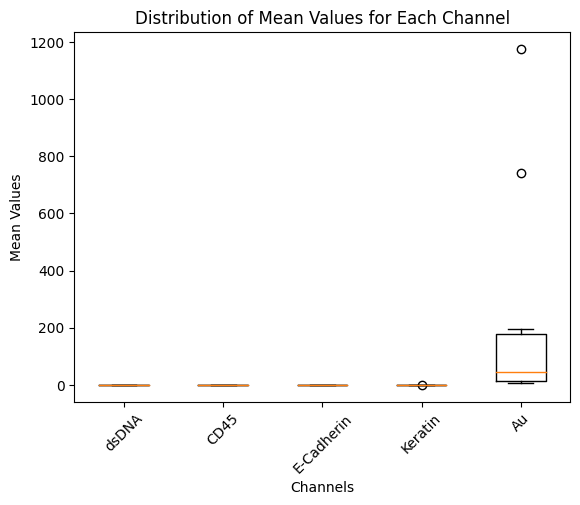

In [5]:
def calculate_mean_value(tiff_dir, fov, tiff):
    mean_values = {}

    for fov_folder in fov:
        mean_values[fov_folder] = {}
        for channel in tiff:
            tiff_path = os.path.join(tiff_dir, fov_folder, f"{channel}.tiff")
            if os.path.exists(tiff_path):
                tiff_data = np.array(Image.open(tiff_path))
                mean_value = np.mean(tiff_data)  # Calculate the mean
                mean_values[fov_folder][channel] = mean_value
            else:
                print(f"Warning: File {channel}.tiff not found in {fov_folder} directory.")

    return mean_values

result = calculate_mean_value(tiff_dir, fov, tiff)

# Flatten the result dictionary into a list of values for each channel
channel_values = {channel: [mean_vals[channel] for fov_folder, mean_vals in result.items()] for channel in tiff}

# Plotting as a single box plot
plt.boxplot(list(channel_values.values()), labels=list(tiff))
plt.xlabel('Channels')
plt.ylabel('Mean Values')
plt.title('Distribution of Mean Values for Each Channel')
plt.xticks(rotation=45)
plt.savefig('Mean_values_per_channel.png')
plt.show()

### Normalizing function for segmentation

In [6]:
## New version that incorporates other factors such as Gamma correction and histogram equalization:
def calculate_range(tiff_dir, fov, tiff):
    range_values = {}

    for fov_folder in fov:
        range_values[fov_folder] = {}
        for channel in tiff:
            tiff_path = os.path.join(tiff_dir, fov_folder, f"{channel}.tiff")
            if os.path.exists(tiff_path):
                tiff_data = np.array(Image.open(tiff_path))
                min_value = np.min(tiff_data)  # Calculate the minimum value
                max_value = np.max(tiff_data)  # Calculate the maximum value
                range_values[fov_folder][channel] = (min_value, max_value)
            else:
                print(f"Warning: File {channel}.tiff not found in {fov_folder} directory.")

    return range_values

#calculate mean range from all the fovs channels
def calculate_mean_range(range_values):
    # Calculate the mean and maximum values for each channel across all FOVs
    all_min_values = {channel: [] for channel in range_values[0]}
    all_max_values = {channel: [] for channel in range_values[0]}
    for fov_range in range_values:
        for channel, (min_val, max_val) in fov_range.items():
            all_min_values[channel].append(min_val)
            all_max_values[channel].append(max_val)
    
    mean_min_values = {channel: np.mean(min_vals) for channel, min_vals in all_min_values.items()}
    mean_max_values = {channel: np.mean(max_vals) for channel, max_vals in all_max_values.items()}
    
    return mean_min_values, mean_max_values

#rescale with optional image sharpening
def rescale_numpy_arrays(range_values, mean_min_values, mean_max_values, sharpen, gamma, gamma_value):
    all_min_values = np.mean(list(mean_min_values.values()))
    all_max_values = np.mean(list(mean_max_values.values()))
    
    for fov_folder, channel_range in range_values.items():
        for channel, (min_val, max_val) in channel_range.items():
            tiff_path = os.path.join(tiff_dir, fov_folder, f"{channel}.tiff")
            if os.path.exists(tiff_path):
                tiff_data = np.array(Image.open(tiff_path))
                rescaled_tiff_data = (tiff_data - min_val) * ((all_max_values - all_min_values) / (max_val - min_val)) + all_min_values

                # Sharpen the image if specified
                if sharpen:
                    rescaled_tiff_data = sharpen_image(rescaled_tiff_data)
                
                # Apply gamma correction if specified
                if gamma:
                    gamma_value = gamma_value  # You can adjust the gamma value as needed
                    rescaled_tiff_data = np.power(rescaled_tiff_data, gamma_value)
            
                # Create the output directory if it doesn't exist
                output_dir = os.path.join(deepcell_files, fov_folder)
                os.makedirs(output_dir, exist_ok=True)

                # Save the rescaled TIFF file
                output_path = os.path.join(output_dir, f"{channel}.tiff")
                image = Image.fromarray(rescaled_tiff_data)
                image.save(output_path)

# Calculate the range for each channel across all FOVs
result_range = calculate_range(tiff_dir, fov, tiff)

# Calculate the mean and maximum values for each channel across all FOVs
mean_min_values, mean_max_values = calculate_mean_range(list(result_range.values()))

# Rescale numpy arrays and save them as TIFFs using the mean range
rescale_numpy_arrays(result_range, mean_min_values, mean_max_values, sharpen = False, gamma = False, 
                     gamma_value = 1
                    )

### Checking output to confirm images have been mean normalized

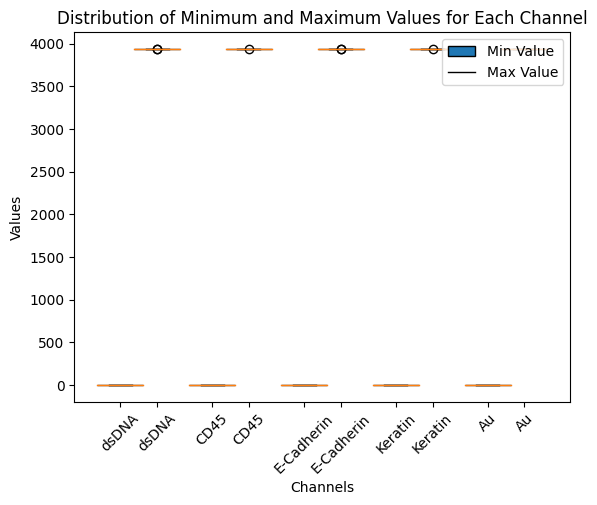

In [7]:
#Plot the differences to ensure that channels were re-scaled correctly.
tiff_dir = deepcell_files
result_range = calculate_range(tiff_dir, fov, tiff)

# Flatten the result dictionary into two lists of values for each channel (min and max)
channel_values_min = {channel: [range_vals[channel][0] for fov_folder, range_vals in result_range.items()] for channel in tiff}
channel_values_max = {channel: [range_vals[channel][1] for fov_folder, range_vals in result_range.items()] for channel in tiff}

# Plotting as a single box plot for each channel's range
plt.boxplot(list(channel_values_min.values()), labels=list(tiff), positions=np.arange(len(tiff))-0.2, patch_artist=True)
plt.boxplot(list(channel_values_max.values()), labels=list(tiff), positions=np.arange(len(tiff))+0.2, patch_artist=True)
plt.xlabel('Channels')
plt.ylabel('Values')
plt.title('Distribution of Minimum and Maximum Values for Each Channel')
plt.xticks(rotation=45)
plt.legend(['Min Value', 'Max Value'], loc='upper right')
plt.savefig('Range_values_per_channel_edited.png')
plt.show()